# Hello variational AutoEncoder for FMNIST dataset

In [1]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
print("TensorFlow Version: ", tf.__version__)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Numpy Version:  2.0.2
Pandas Version:  2.2.3
TensorFlow Version:  2.18.0


### Get Fashion MNIST Dataset

In [2]:
# Get dataset and split into training, validation, and test sets
f_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = f_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

### Build and train the Variational AutoEncoder

Custom layer for sampling the codings

In [17]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) + epsilon

Define encoder and decoder using Keras Functional API

In [40]:
class MyDenseLayer(layers.Layer):
    def __init__(self, units, **kwargs):
        super(MyDenseLayer, self).__init__(**kwargs) 
        self.dense = layers.Dense(units)

    def call(self, inputs):
        return self.dense(inputs)

In [41]:
tf.random.set_seed(42)

codings_size = 10

inputs = layers.Input(shape=[28, 28])
Z = layers.Flatten()(inputs)
Z = layers.Dense(150, activation="relu")(Z)
Z = layers.Dense(100, activation="relu")(Z)
codings_mean = MyDenseLayer(codings_size)(Z)  # μ
codings_log_var = MyDenseLayer(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
ae_variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
         

In [42]:
decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation="relu")(decoder_inputs)
x = layers.Dense(150, activation="relu")(x)
x = layers.Dense(28 * 28)(x)
outputs = layers.Reshape([28, 28])(x)
ae_variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [43]:
_, _, codings = ae_variational_encoder(inputs)
reconstructions = ae_variational_decoder(codings)
ae_variational = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [55]:
#latent_loss = -0.5 * tf.reduce_sum(
#    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)
#ae_variational.add_loss(tf.reduce_mean(latent_loss) / 784.)

ae_variational.compile(loss="mse", optimizer="nadam")

In [48]:
# Note X_train used for both inputs and targets, same for validation data
history = ae_variational.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_val, X_val))    

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0148 - val_loss: 0.0150
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0147 - val_loss: 0.0150
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0150
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0149
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0147 - val_loss: 0.0150
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0146 - val_loss: 0.0150
Epoch 9/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 10/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 11/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 12/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

In [49]:
ae_variational.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_12 (Functional)      │ [(None, 10), (None,    │       134,870 │
│                                 │ 10), (None, 10)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ (None, 28, 28)         │       134,634 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 808,515 (3.08 MB)

 Trainable params: 269,504 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 539,011 (2.06 MB)

### Visualize Reconstruction from dropout images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


d:\MyGithub\ML_TensorFlow_Keras_Experiments\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_17']
Received: inputs=Tensor(shape=(5, 28, 28))
  warnings.warn(msg)
d:\MyGithub\ML_TensorFlow_Keras_Experiments\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(5, 10))
  warnings.warn(msg)


TypeError: Invalid shape (5, 28, 28) for image data

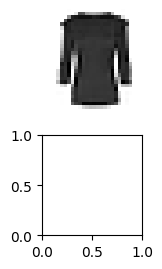

In [16]:
def viz_reconstructions(model, images=X_val, n_images=5):
    reconstruct = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstruct[image_index], cmap="binary")
        plt.axis("off")

viz_reconstructions(ae_variational)
plt.show()

In [50]:
codings = tf.random.normal(shape=[3 * 7, codings_size])
images = ae_variational_decoder(codings).numpy()

d:\MyGithub\ML_TensorFlow_Keras_Experiments\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_108']
Received: inputs=Tensor(shape=(21, 10))
  warnings.warn(msg)


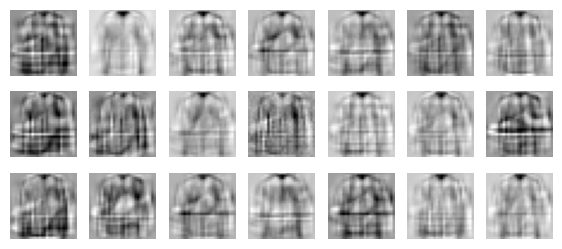

In [51]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()